In [10]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 1. Dataset for all images 

In [11]:
class ODOCSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, mask_key='mask', image_ext='.jpg', mask_ext='.mat'):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.mask_key = mask_key
        self.image_ext = image_ext
        self.mask_ext = mask_ext
        image_files = [f for f in os.listdir(images_dir) if f.endswith(image_ext)]
        self.samples = []
        for img_file in image_files:
            img_id = os.path.splitext(img_file)[0]
            mask_file = img_id + mask_ext
            mask_path = os.path.join(masks_dir, mask_file)
            if os.path.isfile(mask_path):
                self.samples.append((os.path.join(images_dir, img_file), mask_path))
        print(f"Found {len(self.samples)} pairs.")
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        mat = loadmat(mask_path)
        mask = mat[self.mask_key].astype(np.uint8)  # 0=bg, 1=OD, 2=OC
        # Resize mask if needed
        if mask.shape != image.size[::-1]:
            mask = Image.fromarray(mask)
            mask = mask.resize(image.size, resample=Image.NEAREST)
            mask = np.array(mask)
        # To tensor
        image = np.array(image).transpose(2,0,1) / 255.0
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.long)
        return image, mask

In [12]:
img_dir = 'ORIGA/ORIGA/roi_images'
mask_dir = 'ORIGA/ORIGA/Semi-automatic-annotations'

In [13]:
dataset = ODOCSegmentationDataset(img_dir, mask_dir)
loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

Found 650 pairs.


## 4. Model: ResNet34 U-Net

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,   # train from scratch
    in_channels=3,
    classes=3
).to(device)

## 5. Loss and Optimizer

In [15]:
class_weights = torch.tensor([1.0, 30.0, 50.0], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 6. Training loop

In [16]:
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    losses = []
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(losses):.4f}")

Epoch 1/40, Loss: 0.6224
Epoch 2/40, Loss: 0.5396
Epoch 3/40, Loss: 0.4493
Epoch 4/40, Loss: 0.4202
Epoch 5/40, Loss: 0.4167
Epoch 6/40, Loss: 0.4127
Epoch 7/40, Loss: 0.4041
Epoch 8/40, Loss: 0.4053
Epoch 9/40, Loss: 0.4141
Epoch 10/40, Loss: 0.4161
Epoch 11/40, Loss: 0.4060
Epoch 12/40, Loss: 0.3905
Epoch 13/40, Loss: 0.3798
Epoch 14/40, Loss: 0.3802
Epoch 15/40, Loss: 0.3702
Epoch 16/40, Loss: 0.3592
Epoch 17/40, Loss: 0.3844
Epoch 18/40, Loss: 0.3503
Epoch 19/40, Loss: 0.3551
Epoch 20/40, Loss: 0.3527
Epoch 21/40, Loss: 0.3469
Epoch 22/40, Loss: 0.3422
Epoch 23/40, Loss: 0.3491
Epoch 24/40, Loss: 0.3350
Epoch 25/40, Loss: 0.3284
Epoch 26/40, Loss: 0.3305
Epoch 27/40, Loss: 0.3212
Epoch 28/40, Loss: 0.3300
Epoch 29/40, Loss: 0.3284
Epoch 30/40, Loss: 0.3127
Epoch 31/40, Loss: 0.3090
Epoch 32/40, Loss: 0.3025
Epoch 33/40, Loss: 0.2946
Epoch 34/40, Loss: 0.2911
Epoch 35/40, Loss: 0.2915
Epoch 36/40, Loss: 0.2872
Epoch 37/40, Loss: 0.2960
Epoch 38/40, Loss: 0.2983
Epoch 39/40, Loss: 0.

## 7. Visualize prediction

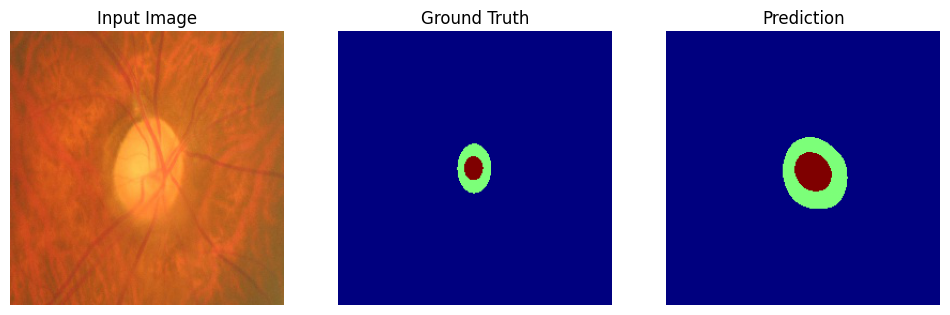

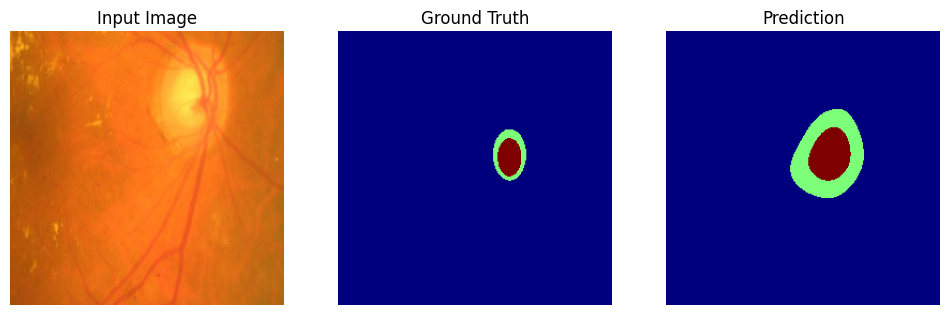

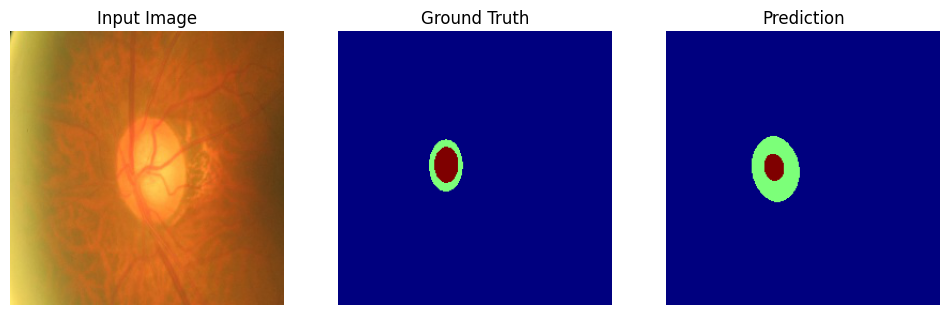

In [33]:
model.eval()
n_show = 3
with torch.no_grad():
    shown = 0
    for images, masks in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu()
        images = images.cpu()
        masks = masks.cpu()
        for i in range(images.shape[0]):
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.imshow(images[i].permute(1,2,0))
            plt.title('Input Image')
            plt.axis('off')
            plt.subplot(1,3,2)
            plt.imshow(masks[i], cmap='jet', vmin=0, vmax=2)
            plt.title('Ground Truth')
            plt.axis('off')
            plt.subplot(1,3,3)
            plt.imshow(preds[i], cmap='jet', vmin=0, vmax=2)
            plt.title('Prediction')
            plt.axis('off')
            plt.show()
            shown += 1
            if shown >= n_show:
                break
        if shown >= n_show:
            break

In [ ]:
import os
import numpy as np
import torch
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score


In [34]:
mat = loadmat('ORIGA/ORIGA/OrigaList.mat')
origa_data = mat['Origa'][0]
filenames, labels = [], []
for row in origa_data:
    filename = row[1][0]              # e.g., '001.jpg'
    label = int(row[4][0][0])         # 0=normal, 1=glaucoma
    filenames.append(filename)
    labels.append(label)
label_dict = {os.path.splitext(fn)[0]: label for fn, label in zip(filenames, labels)}


In [35]:
def compute_cdr(mask):
    od_area = np.sum(mask == 1)
    oc_area = np.sum(mask == 2)
    if od_area == 0:
        return 0.0
    return oc_area / od_area

In [36]:
model.eval()
all_cdrs, all_labels, all_image_ids = [], [], []

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(loader):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()  # shape (B, H, W)
        for i in range(images.shape[0]):
            img_path, _ = dataset.samples[batch_idx * loader.batch_size + i]
            img_id = os.path.splitext(os.path.basename(img_path))[0]
            if img_id not in label_dict:
                continue
            cdr = compute_cdr(preds[i])
            all_cdrs.append(cdr)
            all_labels.append(label_dict[img_id])
            all_image_ids.append(img_id)

print("Sample CDRs:", all_cdrs[:5])


Sample CDRs: [0.14705882352941177, 0.36486486486486486, 0.305168986083499, 0.4090447154471545, 0.0]


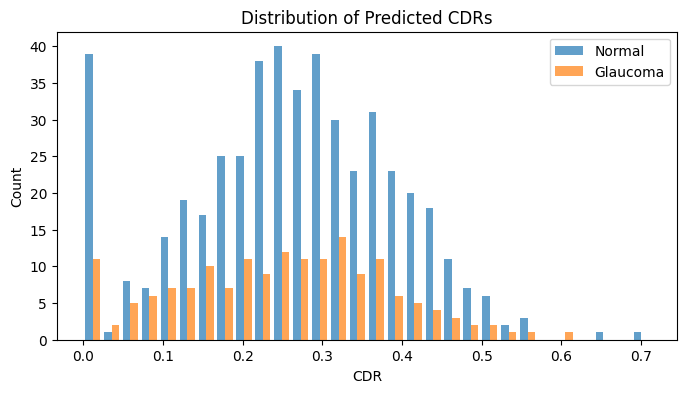

In [37]:
plt.figure(figsize=(8, 4))
plt.hist([np.array(all_cdrs)[np.array(all_labels) == 0], np.array(all_cdrs)[np.array(all_labels) == 1]],
         bins=30, label=['Normal', 'Glaucoma'], alpha=0.7)
plt.xlabel('CDR')
plt.ylabel('Count')
plt.title('Distribution of Predicted CDRs')
plt.legend()
plt.show()

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
X = np.array(all_cdrs).reshape(-1, 1)
y = np.array(all_labels)
clf = LogisticRegression()
clf.fit(X, y)
y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:, 1]
acc = accuracy_score(y, y_pred)
auc = roc_auc_score(y, y_prob)
print(f'CDR-based Classification -- Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}')


CDR-based Classification -- Accuracy: 0.7415, ROC-AUC: 0.5327


In [44]:
from seaborn import sns
plt.figure(figsize=(8, 4))
sns.scatterplot(x=all_cdrs, y=all_labels, hue=all_labels, palette='deep')
plt.plot(np.array(all_cdrs), y_prob, 'r.', label='Predicted probability')
plt.xlabel('CDR')
plt.ylabel('Label / Probability')
plt.title('CDR vs Glaucoma Probability')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'seaborn'